<a href="https://colab.research.google.com/github/sailusha584/Exploratory-data-Analysis/blob/main/28_08_2022_GoodReadsBook_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all required libraries
import pandas as pd
import re
from nltk.stem import PorterStemmer
from ast import literal_eval
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords

In [ ]:
pip install fuzzywuzzy


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# utils import
from fuzzywuzzy import fuzz

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
import numpy as np

In [ ]:
#Load dataset
goodbooks_df = pd.read_csv('books_enriched.csv', index_col=[0], converters={"genres": literal_eval})
ratings_df=pd.read_csv('ratings.csv')
book_tags=pd.read_csv('book_tags.csv')
tags=pd.read_csv('tags.csv')
# shape of dataset

print("shape of book dataset is  " ,goodbooks_df.shape)
print("shape of ratings dataset is " ,ratings_df.shape)
print("shape of book tags dataset is  " ,book_tags.shape)
print("shape of tags dataset is " ,tags.shape)


In [ ]:
goodbooks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   index                      10000 non-null  int64  
 1   authors                    10000 non-null  object 
 2   average_rating             10000 non-null  float64
 3   best_book_id               10000 non-null  int64  
 4   book_id                    10000 non-null  int64  
 5   books_count                10000 non-null  int64  
 6   description                9943 non-null   object 
 7   genres                     10000 non-null  object 
 8   goodreads_book_id          10000 non-null  int64  
 9   image_url                  10000 non-null  object 
 10  isbn                       9300 non-null   object 
 11  isbn13                     9415 non-null   float64
 12  language_code              10000 non-null  object 
 13  original_publication_year  9979 non-null   floa

some missing original titles (585), some pages(73) and descriptions(57) ,publishyear(21),publishDate(8)
compare both publish year and date ans see common years and drop other columns 

In [ ]:
#book id and userid in ratings.csv file 
print("Unique books rated by users are ",ratings_df['book_id'].nunique())
print("Unique users who rated books are ",ratings_df['user_id'].nunique())

Unique books rated by users are  10000
Unique users who rated books are  53424


In [ ]:
#keep only official goodreads genres from the genres column
official_genres = {"art", "biography", "business", "chick-lit", "children's", "christian", "classics",
          "comics", "contemporary", "cookbooks", "crime", "books", "fantasy", "fiction",
          "gay-and-lesbian", "graphic-novels", "historical-fiction", "history", "horror",
          "humor-and-comedy", "manga", "memoir", "music", "mystery", "nonfiction", "paranormal",
          "philosophy", "poetry", "psychology", "religion", "romance", "science", "science-fiction", 
          "self-help", "suspense", "spirituality", "sports", "thriller", "travel", "young-adult"}

goodbooks_df['genres'] = goodbooks_df['genres'].apply(lambda genre: [feature for feature in genre if feature in official_genres])

In [ ]:
goodbooks_df['language_code'].isna().value_counts()

False    10000
Name: language_code, dtype: int64

In [ ]:
#unique book languages
goodbooks_df['language_code'].unique()

array(['eng', 'spa', 'fre', 'sv', 'it', 'de', 'ara', 'da', 'fr', 'por',
       'hu', 'ger', 'es', 'nor', 'jpn', 'ms', 'vie', 'nl', 'pl', 'cs',
       'ind', 'ro', 'af', 'pol', 'tur', 'dan', 'fil', 'ita', 'per', 'mt',
       'id', 'is', 'swe', 'rum', 'mul', 'no', 'zh', 'rus', 'lt', 'fi',
       'et'], dtype=object)

In [ ]:
#find missing languages based on book titles
!pip install langid
import langid

#loop over rows with missing data (see https://stackoverflow.com/questions/23330654/update-a-dataframe-in-pandas-while-iterating-row-by-row)
for index, row in goodbooks_df.iterrows():
    if pd.isna(row["language_code"])==True:
        lang = langid.classify(goodbooks_df.loc[index,'title'])[0]
        goodbooks_df.at[index,'language_code'] = lang

In [ ]:
#unique book languages
goodbooks_df['language_code'].unique()

array(['eng', 'spa', 'fre', 'sv', 'it', 'de', 'ara', 'da', 'fr', 'por',
       'hu', 'ger', 'es', 'nor', 'jpn', 'ms', 'vie', 'nl', 'pl', 'cs',
       'ind', 'ro', 'af', 'pol', 'tur', 'dan', 'fil', 'ita', 'per', 'mt',
       'id', 'is', 'swe', 'rum', 'mul', 'no', 'zh', 'rus', 'lt', 'fi',
       'et'], dtype=object)

In [ ]:
#change all english tags to eng
def change_lang(lang):
    if str(lang)[0:2]=='en':
        return str('eng')
    else:
        return lang

goodbooks_df['language_code'] = goodbooks_df['language_code'].apply(change_lang)

In [ ]:
#keep only english books (9680 books)
(goodbooks_df['language_code']=="eng").sum()
goodbooks_df = goodbooks_df.drop(goodbooks_df[goodbooks_df["language_code"] != "eng"].index)

In [ ]:
#check for duplicates 
#no duplicates by book_id
goodbooks_df['goodreads_book_id'].duplicated().sum()

# there are 36 duplicates by title
goodbooks_df['title'].duplicated().sum()
duplicates = goodbooks_df.loc[(goodbooks_df['title'].duplicated(keep=False))==True,:].sort_values('title')#
duplicates.head(5)

# let's drop them to be on the safe side
goodbooks_df = goodbooks_df.drop_duplicates(subset = ['title'])

In [ ]:
# Dropping columns we will not use for analysis as

goodbooks_df = goodbooks_df.drop(columns=["index",'best_book_id','work_id','ratings_count',
                                  'work_text_reviews_count','authors_2','small_image_url','work_ratings_count'])

In [ ]:
#Index:it is duplicate column for index
#Best book id and work id give ids for popular versions of that book
##ratings_count:It is not much of importance we will drop for now
#work_text_reviews_count: We are not considering reviews in consideration so this is not required 
#authors_2:Duplicated column
#small_image_url:duplicated column
#work_ratings_count:not required
#isbn:unique id ,already exists
#isbn13:unique id already exists
#original_title:It removes series so it is better to be specific abt series incase of harrypotter and other saga
#description:It requres more NLP preprocessing and not required for our problem stmt

In [ ]:
goodbooks_df.head()

,authors,average_rating,book_id,books_count,genres,goodreads_book_id,image_url,language_code,original_publication_year,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,title
0,['Suzanne Collins'],4.34,1,272,"[young-adult, fiction, fantasy, science-fictio...",2767052,https://images.gr-assets.com/books/1447303603m...,eng,2008.0,374.0,09/14/08,66715,127936,560092,1481305,2706317,"The Hunger Games (The Hunger Games, #1)"
1,"['J.K. Rowling', 'Mary GrandPré']",4.44,2,491,"[fantasy, fiction, young-adult, classics]",3,https://images.gr-assets.com/books/1474154022m...,eng,1997.0,309.0,11/01/2003,75504,101676,455024,1156318,3011543,Harry Potter and the Sorcerer's Stone (Harry P...
2,['Stephenie Meyer'],3.57,3,226,"[young-adult, fantasy, romance, fiction, paran...",41865,https://images.gr-assets.com/books/1361039443m...,eng,2005.0,501.0,09/06/2006,456191,436802,793319,875073,1355439,"Twilight (Twilight, #1)"
3,['Harper Lee'],4.25,4,487,"[classics, fiction, historical-fiction, young-...",2657,https://images.gr-assets.com/books/1361975680m...,eng,1960.0,324.0,05/23/06,60427,117415,446835,1001952,1714267,To Kill a Mockingbird
4,['F. Scott Fitzgerald'],3.89,5,1356,"[classics, fiction, historical-fiction, romance]",4671,https://images.gr-assets.com/books/1490528560m...,eng,1925.0,200.0,09/28/04,86236,197621,606158,936012,947718,The Great Gatsby


In [ ]:
goodbooks_df['original_publication_year'].fillna(0,inplace=True)
goodbooks_df['original_publication_year'].isna().value_counts()

False    9964
Name: original_publication_year, dtype: int64

In [ ]:
goobooks_df=goodbooks_df['original_publication_year'].astype(int)

0       2008
1       1997
2       2005
3       1960
4       1925
        ... 
9995    2005
9996    2016
9997    2000
9998    2010
9999    1998
Name: original_publication_year, Length: 9964, dtype: int32

In [ ]:
goodbooks_df['publishDate'] = pd.to_datetime(goodbooks_df['publishDate'])

In [ ]:
goodbooks_df['publishDate'].replace(to_replace='None', value=np.nan)

0                   09/14/08
1                 11/01/2003
2                 09/06/2006
3                   05/23/06
4                   09/28/04
                ...         
9995      ('6', '7', '2005')
9996     ('1', '19', '2016')
9997     ('10', '1', '2000')
9998    ('10', '19', '2010')
9999     ('5', '16', '2000')
Name: publishDate, Length: 9964, dtype: object

In [ ]:
goodbooks_df['publishDate'].fillna(0,inplace=True)

In [ ]:
goodbooks_df['publishDate'].isna().value_counts()

False    9964
Name: publishDate, dtype: int64

In [ ]:
goodbooks_df.to_csv('books_preprocess_13_july.csv',index=False)

# Preprocessed book data 

In [ ]:
goodreads_df=pd.read_csv('books_preprocess_13_july.csv',converters={"genres": literal_eval,"authors":literal_eval})

In [ ]:
goodreads_df.head()

,authors,average_rating,book_id,books_count,genres,goodreads_book_id,image_url,language_code,original_publication_year,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,title
0,[Suzanne Collins],4.34,1,272,"[young-adult, fiction, fantasy, science-fictio...",2767052,https://images.gr-assets.com/books/1447303603m...,eng,2008.0,374.0,09/14/08,66715,127936,560092,1481305,2706317,"The Hunger Games (The Hunger Games, #1)"
1,"[J.K. Rowling, Mary GrandPré]",4.44,2,491,"[fantasy, fiction, young-adult, classics]",3,https://images.gr-assets.com/books/1474154022m...,eng,1997.0,309.0,11/01/2003,75504,101676,455024,1156318,3011543,Harry Potter and the Sorcerer's Stone (Harry P...
2,[Stephenie Meyer],3.57,3,226,"[young-adult, fantasy, romance, fiction, paran...",41865,https://images.gr-assets.com/books/1361039443m...,eng,2005.0,501.0,09/06/2006,456191,436802,793319,875073,1355439,"Twilight (Twilight, #1)"
3,[Harper Lee],4.25,4,487,"[classics, fiction, historical-fiction, young-...",2657,https://images.gr-assets.com/books/1361975680m...,eng,1960.0,324.0,05/23/06,60427,117415,446835,1001952,1714267,To Kill a Mockingbird
4,[F. Scott Fitzgerald],3.89,5,1356,"[classics, fiction, historical-fiction, romance]",4671,https://images.gr-assets.com/books/1490528560m...,eng,1925.0,200.0,09/28/04,86236,197621,606158,936012,947718,The Great Gatsby


In [ ]:
goodreads_df.tail()

,authors,average_rating,book_id,books_count,genres,goodreads_book_id,image_url,language_code,original_publication_year,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,title
9959,[[Jeffery Deaver]],3.98,9981,58,"[mystery, thriller, fiction, crime, suspense, ...",106312,https://images.gr-assets.com/books/1328407138m...,eng,2005.0,816.0,"('6', '7', '2005')",72,390,2874,5155,3643,"The Twelfth Card (Lincoln Rhyme, #6)"
9960,[[Karen Marie Moning]],4.18,9982,1,"[fantasy, paranormal, romance, fiction, myster...",12444298,https://images.gr-assets.com/books/1435195536m...,eng,2016.0,436.0,"('1', '19', '2016')",179,521,2308,4779,6407,"Feverborn (Fever, #8)"
9961,"[[Steve Perry, Tom Clancy, Steve Pieczenik]]",3.69,9985,24,"[fiction, thriller, books, mystery, suspense, ...",19688,https://s.gr-assets.com/assets/nophoto/book/11...,eng,2000.0,368.0,"('10', '1', '2000')",268,684,2349,2456,2068,"Breaking Point (Tom Clancy's Net Force, #4)"
9962,[[Iris Johansen]],4.12,9987,29,"[mystery, fiction, thriller, suspense, crime, ...",8087038,https://s.gr-assets.com/assets/nophoto/book/11...,eng,2010.0,362.0,"('10', '19', '2010')",113,331,2127,3957,4436,"Chasing The Night (Eve Duncan, #11; Catherine ..."
9963,[[John Keegan]],4.00,10000,31,"[history, nonfiction, historical-fiction]",8914,https://images.gr-assets.com/books/1403194704m...,eng,1998.0,475.0,"('5', '16', '2000')",117,345,2031,4138,3069,The First World War


In [ ]:
goodreads_df['original_publication_year']=goodreads_df['original_publication_year'].astype(int)

# preprocessing of ratings-df 

In [ ]:
ratings_df.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
usr_count=ratings_df['user_id'].value_counts(ascending=True)

In [ ]:
usr_count

34590     19
43675     20
40753     21
32128     21
51725     21
        ... 
12381    199
28158    199
52036    199
12874    200
30944    200
Name: user_id, Length: 53424, dtype: int64

In [ ]:
# Select a subset of users

# set sample number
sample_frac=0.1

# sample from user IDs
import numpy as np
import math as math

unique_users = ratings_df["user_id"].nunique()
print(unique_users)
np.random.seed(123)

53424


In [ ]:
# Select a subset of users

# set sample number
sample_frac=0.1

# sample from user IDs
import numpy as np
import math as math

unique_users = ratings_df["user_id"].unique()
print(unique_users)
np.random.seed(123)
user_ids_sample = np.random.choice(unique_users, math.floor(sample_frac*len(unique_users)), replace=False)
print(user_ids_sample)
ratings_sampled = ratings_df[ratings_df["user_id"].isin(user_ids_sample)]
print(ratings_sampled)

[    1     2     4 ... 27329 33111 49802]
[10650 35274 20568 ...  7542 31824 53117]
         user_id  book_id  rating
1              2     4081       4
2              2      260       5
3              2     9296       5
4              2     2318       3
5              2       26       4
...          ...      ...     ...
5976353    50480     1688       3
5976354    50480     2216       4
5976355    50480     1539       3
5976356    50480     2772       4
5976462    15292      854       4

[597029 rows x 3 columns]


In [ ]:
ratings_sampled.nunique()

user_id    5342
book_id    9999
rating        5
dtype: int64

In [ ]:
ratings_df['book_id'].nunique()
#Unique no of books rated by users

10000

In [ ]:
ratings_sampled[ratings_sampled['rating']==5].value_counts(ascending=False)

user_id  book_id  rating
2        2        5         1
36587    6469     5         1
36575    8607     5         1
         8727     5         1
         9327     5         1
                           ..
20254    65       5         1
         70       5         1
         71       5         1
         79       5         1
53415    9472     5         1
Length: 196584, dtype: int64

In [ ]:
#ratings_sampled.groupby(['rating']).sum()

In [ ]:
ratings_sampled[ratings_sampled['user_id']==53415]['rating']==5

5397793     True
5397795     True
5397796     True
5397797     True
5397799     True
           ...  
5828823    False
5867508     True
5902305     True
5937391     True
5937393     True
Name: rating, Length: 92, dtype: bool

In [ ]:
user_preference=ratings_sampled[ratings_sampled['user_id']==53415]

In [ ]:
user_preference

,user_id,book_id,rating
5397793,53415,76,5
5397795,53415,32,5
5397796,53415,402,5
5397797,53415,1088,5
5397799,53415,9472,5
...,...,...,...
5828823,53415,407,3
5867508,53415,2268,5
5902305,53415,6569,5
5937391,53415,7978,5


In [ ]:
user_fav_books=user_preference.loc[user_preference['rating'].isin([4,5]),'book_id']

In [ ]:
user_fav_genres=goodreads_df.loc[user_fav_books,'genres']

In [ ]:
genre_list=list(user_fav_genres)

In [ ]:
from collections import Counter

In [ ]:
flat_list = [item for sublist in genre_list for item in sublist]
print('Original list', genre_list)
print('Transformed list', flat_list)

Original list [['classics', 'fiction', 'poetry', 'young-adult', 'fantasy'], ['fantasy', 'classics', 'fiction', 'young-adult', 'christian'], ['historical-fiction', 'fiction'], ['fiction', 'graphic-novels', 'young-adult', 'comics'], ['science', 'spirituality', 'philosophy', 'nonfiction', 'self-help', 'psychology', 'religion', 'history', 'business', 'christian'], ['science-fiction', 'fiction', 'fantasy', 'classics'], ['fiction', 'historical-fiction', 'mystery', 'romance', 'contemporary'], ['nonfiction', 'memoir', 'biography', 'travel', 'cookbooks'], ['fiction', 'mystery', 'thriller', 'crime', 'suspense'], ['nonfiction', 'business', 'science', 'psychology'], ['fantasy', 'classics', 'fiction', 'young-adult'], ['fiction', 'science-fiction', 'classics', 'horror', 'contemporary'], ['fiction', 'sports', 'contemporary'], ['horror', 'fantasy', 'fiction', 'paranormal'], ['young-adult', 'contemporary', 'fiction', 'romance', 'mystery'], ['fantasy', 'young-adult', 'paranormal', 'romance', 'fiction'],

In [ ]:
count_genres=Counter(flat_list)

In [ ]:
count_genres

Counter({'classics': 29,
         'fiction': 63,
         'poetry': 2,
         'young-adult': 25,
         'fantasy': 27,
         'christian': 3,
         'historical-fiction': 14,
         'graphic-novels': 3,
         'comics': 3,
         'science': 3,
         'spirituality': 1,
         'philosophy': 3,
         'nonfiction': 12,
         'self-help': 2,
         'psychology': 3,
         'religion': 1,
         'history': 7,
         'business': 3,
         'science-fiction': 11,
         'mystery': 11,
         'romance': 19,
         'contemporary': 15,
         'memoir': 6,
         'biography': 7,
         'travel': 1,
         'cookbooks': 1,
         'thriller': 6,
         'crime': 5,
         'suspense': 5,
         'horror': 5,
         'sports': 1,
         'paranormal': 8,
         'chick-lit': 5,
         'art': 1,
         'books': 1,
         'manga': 1})

top 3 genres of user  53415 is fiction,classics,fantasy 

In [ ]:
#remove books he has rated and consider other books with three genres 

In [ ]:
uncommon_books=goodreads_df.copy()

In [ ]:
compared_column=np.where(user_preference['book_id'].isin(goodreads_df['book_id']),True,False)

In [ ]:
compared_column

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [ ]:
uncommon_books["equal_book_id"]=compared_column

In [ ]:
uncommon_books[uncommon_books['equal_book_id']==False]['book_id']

Series([], Name: book_id, dtype: int64)

In [ ]:
for row in ratings_df.itertuples():
    item_id=row.book_id
    
    user_id.extend(row.user_id)
    for i in user_id:
        if ()
    rating=row.rating
    

### ITEM-KNN CBF ###

In [ ]:
df_book_titles = goodreads_df.filter(['book_id','title'])

In [ ]:
df_book_titles.head()


,book_id,title
0,1,"The Hunger Games (The Hunger Games, #1)"
1,2,Harry Potter and the Sorcerer's Stone (Harry P...
2,3,"Twilight (Twilight, #1)"
3,4,To Kill a Mockingbird
4,5,The Great Gatsby


In [ ]:
df_book_titles.isna().count()

book_id    9964
title      9964
dtype: int64

In [ ]:
len(ratings_df['book_id'].unique())

10000

In [ ]:
ratings_df['book_id'].unique()

array([ 258, 4081,  260, ..., 9580, 8892, 9548], dtype=int64)

In [ ]:
df_books = pd.DataFrame(ratings_df['book_id'].unique())

In [ ]:
df_books.rename(columns={0:'book_id'},inplace=True)

In [ ]:
df_books['book_id'].isin(df_book_titles['book_id']).value_counts()

True     9964
False      36
Name: book_id, dtype: int64

In [ ]:
df_book_titles.duplicated(subset=['book_id']).value_counts()

False    9964
dtype: int64

In [ ]:
remain_books=pd.concat([df_books['book_id'],df_book_titles['book_id']]).drop_duplicates(keep=False)

In [ ]:
remain_books

426     7462
1155    4271
1533    7003
1698    4939
1915    6481
2203    6648
2378    5617
2598    8221
2641    8168
2670    3802
2683    7684
2684    7025
3785    9813
3878    8899
3882    9784
4305    5480
4646    4375
4764    9297
4773    5268
5266    7023
5312    7761
5432    8969
5464    9112
5539    6662
5820    3912
6325    1292
6461    7449
7111    7645
7658    5832
7782    4812
8048    9120
8138    5787
9288    5174
9294    4212
9619    8744
9631    2401
Name: book_id, dtype: int64

In [ ]:
ratings_df_cpy=ratings_df.copy()

In [ ]:
ratings_df_cpy = ratings_df_cpy[~ratings_df_cpy.book_id.isin(remain_books)]

In [ ]:
ratings_df_cpy.shape

(5968218, 3)

In [ ]:
ratings_df.shape

(5976479, 3)

In [ ]:
ratings_df_cpy['book_id'].nunique()

9964

In [ ]:
df_book_titles.set_index('book_id').loc[df_book_features.index]

,title
book_id,
1,"The Hunger Games (The Hunger Games, #1)"
2,Harry Potter and the Sorcerer's Stone (Harry P...
3,"Twilight (Twilight, #1)"
4,To Kill a Mockingbird
5,The Great Gatsby
...,...
9996,"Bayou Moon (The Edge, #2)"
9997,"Means of Ascent (The Years of Lyndon Johnson, #2)"
9998,The Mauritius Command


##Fuzzy matching is done using Levenstein distance .
The Levenshtein distance is a number that tells you how different two strings are. The higher the number, the more different the two strings are.

For example, the Levenshtein distance between “kitten” and “sitting” is 3 since, at a minimum, 3 edits are required to change one into the other.

In [ ]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_book_features = ratings_df_cpy.pivot(
    index='book_id',
    columns='user_id',
    values='rating'
)

In [ ]:
df_book_features=df_book_features.fillna(0)

In [ ]:
df_book_features

user_id,1,2,3,4,5,6,7,8,9,10,...,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
book_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,4.0,5.0,4.0,4.0,4.0,4.0,4.0,4.0
2,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,5.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0
4,5.0,0.0,3.0,4.0,0.0,0.0,0.0,3.0,0.0,5.0,...,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,5.0,5.0
5,0.0,5.0,0.0,4.0,0.0,0.0,3.0,3.0,5.0,5.0,...,0.0,0.0,0.0,0.0,3.0,2.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_book_features.tail()

user_id,1,2,3,4,5,6,7,8,9,10,...,53415,53416,53417,53418,53419,53420,53421,53422,53423,53424
book_id,,,,,,,,,,,,,,,,,,,,,
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# create mapper from book title to index
book_to_idx = {
    book: i for i, book in 
    enumerate(list(df_book_titles.set_index('book_id').loc[df_book_features.index].title))}
# transform matrix to scipy sparse matrix
book_user_mat_sparse = csr_matrix(df_book_features.values)

In [ ]:
book_to_idx

{'The Hunger Games (The Hunger Games, #1)': 0,
 "Harry Potter and the Sorcerer's Stone (Harry Potter, #1)": 1,
 'Twilight (Twilight, #1)': 2,
 'To Kill a Mockingbird': 3,
 'The Great Gatsby': 4,
 'The Fault in Our Stars': 5,
 'The Hobbit': 6,
 'The Catcher in the Rye': 7,
 'Angels & Demons  (Robert Langdon, #1)': 8,
 'Pride and Prejudice': 9,
 'The Kite Runner': 10,
 'Divergent (Divergent, #1)': 11,
 '1984': 12,
 'Animal Farm': 13,
 'The Diary of a Young Girl': 14,
 'The Girl with the Dragon Tattoo (Millennium, #1)': 15,
 'Catching Fire (The Hunger Games, #2)': 16,
 'Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)': 17,
 'The Fellowship of the Ring (The Lord of the Rings, #1)': 18,
 'Mockingjay (The Hunger Games, #3)': 19,
 'Harry Potter and the Order of the Phoenix (Harry Potter, #5)': 20,
 'The Lovely Bones': 21,
 'Harry Potter and the Chamber of Secrets (Harry Potter, #2)': 22,
 'Harry Potter and the Goblet of Fire (Harry Potter, #4)': 23,
 'Harry Potter and the Deathly 

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn_euc = NearestNeighbors(metric='euclidean', algorithm='auto', n_neighbors=21, n_jobs=-1)

In [ ]:
from sklearn.neighbors import NearestNeighbors
model_knn_cos = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=21, n_jobs=-1)

In [ ]:
# fit
model_knn_euc.fit(book_user_mat_sparse)

NearestNeighbors(metric='euclidean', n_jobs=-1, n_neighbors=21)

In [ ]:
# fit
model_knn_cos.fit(book_user_mat_sparse)

NearestNeighbors(metric='cosine', n_jobs=-1, n_neighbors=21)

In [ ]:
def fuzzy_matching(mapper, fav_book, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map book title name to index of the book in data

    fav_book: str, name of user input book
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_book.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [ ]:
def make_recommendation(model_knn, data, mapper, fav_book, n_recommendations):
    """
    return top n similar book recommendations based on user's input book


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: book-user matrix

    mapper: dict, map book title name to index of the book in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar book recommendations
    """
    # fit
    model_knn.fit(data)
    # get input book index
    print('You have input book:', fav_book)
    idx = fuzzy_matching(mapper, fav_book, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_book))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite =input("enter a book name to get recommendations: ")

enter a book name to get recommendations: great gatsby


In [ ]:
make_recommendation(
    model_knn=model_knn_euc,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=book_to_idx,
    n_recommendations=10)

In [ ]:
make_recommendation(
    model_knn=model_knn_cos,
    data=book_user_mat_sparse,
    fav_book=my_favorite,
    mapper=book_to_idx,
    n_recommendations=10)

You have input book: great gatsby
Found possible matches in our database: ['The Great Gatsby', 'Great House', 'Great Expectations']

Recommendation system start to make inference
......

Recommendations for great gatsby:
1: Jane Eyre, with distance of 0.579522894680147
2: Harry Potter and the Sorcerer's Stone (Harry Potter, #1), with distance of 0.5582313787650417
3: Romeo and Juliet, with distance of 0.5505435126812175
4: Pride and Prejudice, with distance of 0.5339919124048029
5: Of Mice and Men, with distance of 0.520644336516682
6: Lord of the Flies, with distance of 0.5138332669969189
7: 1984, with distance of 0.5107401410708425
8: Animal Farm, with distance of 0.5071120285008361
9: The Catcher in the Rye, with distance of 0.42258644652160393
10: To Kill a Mockingbird, with distance of 0.41241357945119217


In [ ]:
##Evaluation metric:

In [ ]:
##Fuzzy matching with KNN is computationally expensive with  quadratic time complexity.It is difficult  for large datasets and also suffers from cold start scenario 

In [ ]:
##Optimised Fuzzy matching TF-IDF with KNN 

In [ ]:
# Import module for data manipulation
import pandas as pd
# Import module for linear algebra
import numpy as np
# Import module for Fuzzy string matching
from fuzzywuzzy import fuzz, process
# Import module for regex
import re
# Import module for iteration
import itertools
# Import module for function development
from typing import Union, List, Tuple
# Import module for TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
# Import module for cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
# Import module for KNN
from sklearn.neighbors import NearestNeighbors

In [ ]:
def build_vectorizer(
    clean: pd.Series,
    analyzer: str = 'char', 
    ngram_range: Tuple[int, int] = (1, 4), 
    n_neighbors: int = 1, 
    **kwargs
    ) -> Tuple:
    # Create vectorizer
    vectorizer = TfidfVectorizer(analyzer = analyzer, ngram_range = ngram_range, **kwargs)
    X = vectorizer.fit_transform(clean.values.astype('U'))

    # Fit nearest neighbors corpus
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, metric = 'cosine').fit(X)
    return vectorizer, nbrs

In [ ]:
def build_vectorizer(
    clean: pd.Series,
    analyzer: str = 'char', 
    ngram_range: Tuple[int, int] = (1, 4), 
    n_neighbors: int = 1, 
    **kwargs
    ) -> Tuple:
    # Create vectorizer
    vectorizer = TfidfVectorizer(analyzer = analyzer, ngram_range = ngram_range, **kwargs)
    X = vectorizer.fit_transform(clean.values.astype('U'))

    # Fit nearest neighbors corpus
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, metric = 'cosine').fit(X)
    return vectorizer, nbrs

# String matching - KNN
def tfidf_nn(
    messy, 
    clean, 
    n_neighbors = 1, 
    **kwargs
    ):
    # Fit clean data and transform messy data
    vectorizer, nbrs = build_vectorizer(clean, n_neighbors = n_neighbors, **kwargs)
    input_vec = vectorizer.transform(messy)

    # Determine best possible matches
    distances, indices = nbrs.kneighbors(input_vec, n_neighbors = n_neighbors)
    nearest_values = np.array(clean)[indices]
    return nearest_values, distances


In [ ]:
# String pre-processing
def preprocess_string(s):
    # Remove spaces between strings with one or two letters
    s = re.sub(r'(?<=\b\w)\s*[ &]\s*(?=\w\b)', '', s)
    return s

In [ ]:
tfidf_nn

In [ ]:
# String matching - TF-IDF
def fuzzy_nn_match(
    messy,
    clean,
    column,
    col,
    n_neighbors = 100,
    limit = 5, **kwargs):
    nearest_values, _ = tfidf_nn(messy, clean, n_neighbors, **kwargs)

    results = [find_matches_fuzzy(row, nearest_values[i], limit) for i, row in enumerate(messy)]
    df = pd.DataFrame(itertools.chain.from_iterable(results),
        columns = [column, col, 'Ratio']
        )
    return df

In [ ]:
# String matching - Fuzzy
def fuzzy_tf_idf(
    df: pd.DataFrame,
    column: str,
    clean: pd.Series,
    mapping_df: pd.DataFrame,
    col: str,
    analyzer: str = 'char',
    ngram_range: Tuple[int, int] = (1, 3)
    ) -> pd.Series:
    # Create vectorizer
    clean = clean.drop_duplicates().reset_index(drop = True)
    messy_prep = df[column].drop_duplicates().dropna().reset_index(drop = True).astype(str)
    messy = messy_prep.apply(preprocess_string)
    result = fuzzy_nn_match(messy = messy, clean = clean, column = column, col = col, n_neighbors = 1)
    # Map value from messy to clean
    return result

In [ ]:
goodreads_df['original_title']=goodbooks_df['original_title']

In [ ]:
goodreads_df

,authors,average_rating,book_id,books_count,genres,goodreads_book_id,image_url,language_code,original_publication_year,pages,publishDate,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,title,original_title
0,[Suzanne Collins],4.34,1,272,"[young-adult, fiction, fantasy, science-fictio...",2767052,https://images.gr-assets.com/books/1447303603m...,eng,2008,374.0,09/14/08,66715,127936,560092,1481305,2706317,"The Hunger Games (The Hunger Games, #1)",The Hunger Games
1,"[J.K. Rowling, Mary GrandPré]",4.44,2,491,"[fantasy, fiction, young-adult, classics]",3,https://images.gr-assets.com/books/1474154022m...,eng,1997,309.0,11/01/2003,75504,101676,455024,1156318,3011543,Harry Potter and the Sorcerer's Stone (Harry P...,Harry Potter and the Philosopher's Stone
2,[Stephenie Meyer],3.57,3,226,"[young-adult, fantasy, romance, fiction, paran...",41865,https://images.gr-assets.com/books/1361039443m...,eng,2005,501.0,09/06/2006,456191,436802,793319,875073,1355439,"Twilight (Twilight, #1)",Twilight
3,[Harper Lee],4.25,4,487,"[classics, fiction, historical-fiction, young-...",2657,https://images.gr-assets.com/books/1361975680m...,eng,1960,324.0,05/23/06,60427,117415,446835,1001952,1714267,To Kill a Mockingbird,To Kill a Mockingbird
4,[F. Scott Fitzgerald],3.89,5,1356,"[classics, fiction, historical-fiction, romance]",4671,https://images.gr-assets.com/books/1490528560m...,eng,1925,200.0,09/28/04,86236,197621,606158,936012,947718,The Great Gatsby,The Great Gatsby
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9959,[[Jeffery Deaver]],3.98,9981,58,"[mystery, thriller, fiction, crime, suspense, ...",106312,https://images.gr-assets.com/books/1328407138m...,eng,2005,816.0,"('6', '7', '2005')",72,390,2874,5155,3643,"The Twelfth Card (Lincoln Rhyme, #6)",The Versions of Us
9960,[[Karen Marie Moning]],4.18,9982,1,"[fantasy, paranormal, romance, fiction, myster...",12444298,https://images.gr-assets.com/books/1435195536m...,eng,2016,436.0,"('1', '19', '2016')",179,521,2308,4779,6407,"Feverborn (Fever, #8)",The Honest Truth About Dishonesty: How We Lie ...
9961,"[[Steve Perry, Tom Clancy, Steve Pieczenik]]",3.69,9985,24,"[fiction, thriller, books, mystery, suspense, ...",19688,https://s.gr-assets.com/assets/nophoto/book/11...,eng,2000,368.0,"('10', '1', '2000')",268,684,2349,2456,2068,"Breaking Point (Tom Clancy's Net Force, #4)",Locked On
9962,[[Iris Johansen]],4.12,9987,29,"[mystery, fiction, thriller, suspense, crime, ...",8087038,https://s.gr-assets.com/assets/nophoto/book/11...,eng,2010,362.0,"('10', '19', '2010')",113,331,2127,3957,4436,"Chasing The Night (Eve Duncan, #11; Catherine ...",The Bookman’s Tale


In [ ]:
# String matching - match fuzzy
def find_matches_fuzzy(
    row, 
    match_candidates, 
    limit = 5
    ):
    row_matches = process.extract(
        row, dict(enumerate(match_candidates)), 
        scorer = fuzz.token_sort_ratio, 
        limit = limit
        )
    result = [(row, match[0], match[1]) for match in row_matches]
    return result

In [ ]:
df_result = (goodreads_df.pipe(fuzzy_tf_idf, # Function and messy data
                     column = 'original_title', # Messy column in data
                     clean = goodreads_df['title'], # Master data (list)
                     mapping_df = goodreads_df, # Master data
                     col = 'Result') # Can be customized
            )


In [ ]:
df_result

,original_title,Result,Ratio
0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",63
1,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,72
2,Twilight,"Twilight (Twilight, #1)",59
3,To Kill a Mockingbird,To Kill a Mockingbird,100
4,The Great Gatsby,The Great Gatsby,100
...,...,...,...
9237,The Versions of Us,The Versions of Us,100
9238,The Honest Truth About Dishonesty: How We Lie ...,The Honest Truth About Dishonesty: How We Lie ...,100
9239,Locked On,"Locked On (Jack Ryan Universe, #14)",45
9240,The Bookman’s Tale,The Bookman’s Tale,100


In [ ]:
## ITEM KNN CBF Using Suprise Package

In [ ]:
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 7.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633980 sha256=9ee27b25f0431d492c97a22b9bac11d7020bebb576e96c962eed2b8c6320888f
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns
from surprise.model_selection import GridSearchCV

In [ ]:
ratings_df=pd.read_csv('/content/drive/MyDrive/Goodreads_dataset/ratings.csv')

In [ ]:
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings_df, reader)
anti_set = data.build_full_trainset().build_anti_testset()

In [ ]:
anti_set

[(1, 4081, 3.9198655261735214),
 (1, 260, 3.9198655261735214),
 (1, 9296, 3.9198655261735214),
 (1, 2318, 3.9198655261735214),
 (1, 26, 3.9198655261735214),
 (1, 315, 3.9198655261735214),
 (1, 301, 3.9198655261735214),
 (1, 2686, 3.9198655261735214),
 (1, 3753, 3.9198655261735214),
 (1, 8519, 3.9198655261735214),
 (1, 264, 3.9198655261735214),
 (1, 388, 3.9198655261735214),
 (1, 18, 3.9198655261735214),
 (1, 27, 3.9198655261735214),
 (1, 21, 3.9198655261735214),
 (1, 2, 3.9198655261735214),
 (1, 23, 3.9198655261735214),
 (1, 24, 3.9198655261735214),
 (1, 964, 3.9198655261735214),
 (1, 337, 3.9198655261735214),
 (1, 84, 3.9198655261735214),
 (1, 58, 3.9198655261735214),
 (1, 1117, 3.9198655261735214),
 (1, 660, 3.9198655261735214),
 (1, 5, 3.9198655261735214),
 (1, 413, 3.9198655261735214),
 (1, 8, 3.9198655261735214),
 (1, 2172, 3.9198655261735214),
 (1, 65, 3.9198655261735214),
 (1, 297, 3.9198655261735214),
 (1, 113, 3.9198655261735214),
 (1, 476, 3.9198655261735214),
 (1, 6351, 3.91

# finding similar books based on genres 

# Preprocessing of genres column in book dataset

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_book_genres = goodreads_df.filter(['book_id','genres','title'])

In [ ]:
df_book_genres

,book_id,genres
0,1,"[young-adult, fiction, fantasy, science-fictio..."
1,2,"[fantasy, fiction, young-adult, classics]"
2,3,"[young-adult, fantasy, romance, fiction, paran..."
3,4,"[classics, fiction, historical-fiction, young-..."
4,5,"[classics, fiction, historical-fiction, romance]"
...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ..."
9960,9982,"[fantasy, paranormal, romance, fiction, myster..."
9961,9985,"[fiction, thriller, books, mystery, suspense, ..."
9962,9987,"[mystery, fiction, thriller, suspense, crime, ..."


# Genre Matrix for recommendations based on genre

In [ ]:
df_book_genres.set_index('book_id')

,genres
book_id,
1,"[young-adult, fiction, fantasy, science-fictio..."
2,"[fantasy, fiction, young-adult, classics]"
3,"[young-adult, fantasy, romance, fiction, paran..."
4,"[classics, fiction, historical-fiction, young-..."
5,"[classics, fiction, historical-fiction, romance]"
...,...
9981,"[mystery, thriller, fiction, crime, suspense, ..."
9982,"[fantasy, paranormal, romance, fiction, myster..."
9985,"[fiction, thriller, books, mystery, suspense, ..."


# Preprocessing of Authors column

In [ ]:
##Top Authors 

In [ ]:
df_book_genres['authors']=goodreads_df['authors']

In [ ]:
df_book_genres.head()

,book_id,genres,authors
0,1,"[young-adult, fiction, fantasy, science-fictio...",[Suzanne Collins]
1,2,"[fantasy, fiction, young-adult, classics]","[J.K. Rowling, Mary GrandPré]"
2,3,"[young-adult, fantasy, romance, fiction, paran...",[Stephenie Meyer]
3,4,"[classics, fiction, historical-fiction, young-...",[Harper Lee]
4,5,"[classics, fiction, historical-fiction, romance]",[F. Scott Fitzgerald]


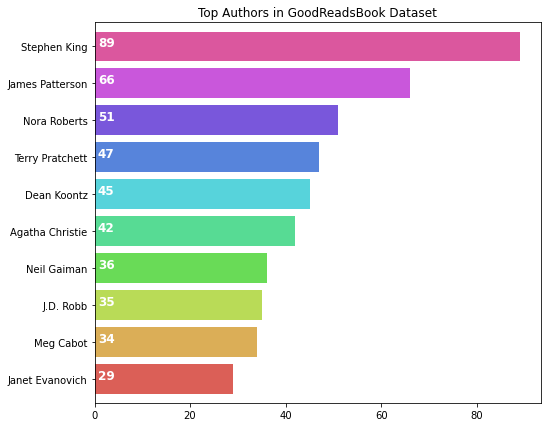

In [ ]:
plt.subplots(figsize=(8,7))
author_list = []
for i in df_book_genres['authors']:
    author_list.extend(i)
ax = pd.Series(author_list).value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.8,color=sns.color_palette('hls',10))
for i, v in enumerate(pd.Series(author_list).value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.7, i, v,fontsize=12,color='white',weight='bold')
plt.title('Top Authors in GoodReadsBook Dataset')
plt.show()

# Generation of Genre Binary Matrix 

In [ ]:
#genre list from book dataset as each book can be recognised with more than 2 genres
genreList = []
for index, row in df_book_genres.iterrows():
    genres = row["genres"]
    
    for genre in genres:
        if genre not in genreList:
            genreList.append(genre)

In [ ]:
print(genreList)

['young-adult', 'fiction', 'fantasy', 'science-fiction', 'romance', 'classics', 'paranormal', 'historical-fiction', 'contemporary', 'mystery', 'thriller', 'suspense', 'crime', 'nonfiction', 'history', 'biography', 'memoir', 'poetry', 'chick-lit', 'christian', 'travel', 'spirituality', 'philosophy', 'psychology', 'horror', 'business', 'science', 'religion', 'self-help', 'art', 'music', 'graphic-novels', 'comics', 'sports', 'manga', 'cookbooks', 'books', 'humor-and-comedy', 'gay-and-lesbian']


In [ ]:
def binary(genre_list):
    binaryList = []
    
    for genre in genreList:
        if genre in genre_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
df_book_genres['genres_bin'] = df_book_genres['genres'].apply(lambda x: binary(x))
df_book_genres['genres_bin'].head()

0    [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
Name: genres_bin, dtype: object

In [ ]:
df_book_genres['genres']

0       [young-adult, fiction, fantasy, science-fictio...
1               [fantasy, fiction, young-adult, classics]
2       [young-adult, fantasy, romance, fiction, paran...
3       [classics, fiction, historical-fiction, young-...
4        [classics, fiction, historical-fiction, romance]
                              ...                        
9959    [mystery, thriller, fiction, crime, suspense, ...
9960    [fantasy, paranormal, romance, fiction, myster...
9961    [fiction, thriller, books, mystery, suspense, ...
9962    [mystery, fiction, thriller, suspense, crime, ...
9963            [history, nonfiction, historical-fiction]
Name: genres, Length: 9964, dtype: object

In [ ]:
df_book_genres

,book_id,genres,authors,genres_bin
0,1,"[young-adult, fiction, fantasy, science-fictio...",[Suzanne Collins],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[fantasy, fiction, young-adult, classics]","[J.K. Rowling, Mary GrandPré]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[young-adult, fantasy, romance, fiction, paran...",[Stephenie Meyer],"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[classics, fiction, historical-fiction, young-...",[Harper Lee],"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[classics, fiction, historical-fiction, romance]",[F. Scott Fitzgerald],"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ...",[[Jeffery Deaver]],"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ..."
9960,9982,"[fantasy, paranormal, romance, fiction, myster...",[[Karen Marie Moning]],"[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, ..."
9961,9985,"[fiction, thriller, books, mystery, suspense, ...","[[Steve Perry, Tom Clancy, Steve Pieczenik]]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ..."
9962,9987,"[mystery, fiction, thriller, suspense, crime, ...",[[Iris Johansen]],"[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ..."


In [ ]:
from scipy import spatial
def Similarity(bookId1, bookId2):
    a = df_book_genres.iloc[bookId1]
    b = df_book_genres.iloc[bookId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance = spatial.distance.cosine(genresA, genresB)
   
    
    return genreDistance

In [ ]:
Similarity(4,1)

0.5

# Generation of Author Binary Matrix 

In [ ]:
df_book_genres['authors']

0                                  [Suzanne Collins]
1                      [J.K. Rowling, Mary GrandPré]
2                                  [Stephenie Meyer]
3                                       [Harper Lee]
4                              [F. Scott Fitzgerald]
                            ...                     
9959                              [[Jeffery Deaver]]
9960                          [[Karen Marie Moning]]
9961    [[Steve Perry, Tom Clancy, Steve Pieczenik]]
9962                               [[Iris Johansen]]
9963                                 [[John Keegan]]
Name: authors, Length: 9964, dtype: object

In [ ]:
authorList=[]
for index, row in df_book_genres.iterrows():
    authors = row["authors"]
    
    for i in authors:
        if i not in authorList:
            authorList.append(i)
            df_book_genres['author_bin'] = df_book_genres['authors'].apply(lambda x: binary(x))
df_book_genres['author_bin'].head()

0    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: author_bin, dtype: object

In [ ]:
df_book_genres

,book_id,genres,authors,genres_bin,author_bin
0,1,"[young-adult, fiction, fantasy, science-fictio...",[Suzanne Collins],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[fantasy, fiction, young-adult, classics]","[J.K. Rowling, Mary GrandPré]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[young-adult, fantasy, romance, fiction, paran...",[Stephenie Meyer],"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[classics, fiction, historical-fiction, young-...",[Harper Lee],"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[classics, fiction, historical-fiction, romance]",[F. Scott Fitzgerald],"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ...",[[Jeffery Deaver]],"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9960,9982,"[fantasy, paranormal, romance, fiction, myster...",[[Karen Marie Moning]],"[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9961,9985,"[fiction, thriller, books, mystery, suspense, ...","[[Steve Perry, Tom Clancy, Steve Pieczenik]]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9962,9987,"[mystery, fiction, thriller, suspense, crime, ...",[[Iris Johansen]],"[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
authorList

['Suzanne Collins',
 'J.K. Rowling',
 'Mary GrandPré',
 'Stephenie Meyer',
 'Harper Lee',
 'F. Scott Fitzgerald',
 'John Green',
 'J.R.R. Tolkien',
 'J.D. Salinger',
 'Dan Brown',
 'Jane Austen',
 'Khaled Hosseini',
 'Veronica Roth',
 'Anne Frank',
 'Eleanor Roosevelt',
 'B.M. Mooyaart-Doubleday',
 'Stieg Larsson',
 'Reg Keeland',
 'Rufus Beck',
 'Alice Sebold',
 'William Golding',
 'William Shakespeare',
 'Robert           Jackson',
 'Gillian Flynn',
 'Kathryn Stockett',
 'John Steinbeck',
 'Arthur Golden',
 'E.L. James',
 'Lois Lowry',
 'C.S. Lewis',
 'Audrey Niffenegger',
 'George R.R. Martin',
 'Elizabeth Gilbert',
 'Rick Riordan',
 'Louisa May Alcott',
 'Charlotte Brontë',
 'Michael Mason',
 'Yann Martel',
 'Sara Gruen',
 'Markus Zusak',
 'Shel Silverstein',
 'Cassandra Clare',
 'Christopher Paolini',
 'Douglas Adams',
 'Aldous Huxley',
 'Sue Monk Kidd',
 'Mark Twain',
 'John Seelye',
 'Guy Cardwell',
 'E.B. White',
 'Garth Williams',
 'Rosemary Wells',
 'Mark Haddon',
 'Paula Haw

In [ ]:
df_book_genres.drop(columns=['author_bin'],inplace=True)

In [ ]:
df_book_genres

,book_id,genres,genres_bin,authors
0,1,"[young-adult, fiction, fantasy, science-fictio...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suzanne Collins]
1,2,"[fantasy, fiction, young-adult, classics]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[J.K. Rowling, Mary GrandPré]"
2,3,"[young-adult, fantasy, romance, fiction, paran...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Stephenie Meyer]
3,4,"[classics, fiction, historical-fiction, young-...","[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[Harper Lee]
4,5,"[classics, fiction, historical-fiction, romance]","[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[F. Scott Fitzgerald]
...,...,...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...",[[Jeffery Deaver]]
9960,9982,"[fantasy, paranormal, romance, fiction, myster...","[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...",[[Karen Marie Moning]]
9961,9985,"[fiction, thriller, books, mystery, suspense, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[[Steve Perry, Tom Clancy, Steve Pieczenik]]"
9962,9987,"[mystery, fiction, thriller, suspense, crime, ...","[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...",[[Iris Johansen]]


In [ ]:
authorList = []
for index, row in df_book_genres.iterrows():
    authors = row["authors"]
    
    for i in authors:
        if i not in authorList:
            authorList.append(i)

In [ ]:
authorList

['Suzanne Collins',
 'J.K. Rowling',
 'Mary GrandPré',
 'Stephenie Meyer',
 'Harper Lee',
 'F. Scott Fitzgerald',
 'John Green',
 'J.R.R. Tolkien',
 'J.D. Salinger',
 'Dan Brown',
 'Jane Austen',
 'Khaled Hosseini',
 'Veronica Roth',
 'Anne Frank',
 'Eleanor Roosevelt',
 'B.M. Mooyaart-Doubleday',
 'Stieg Larsson',
 'Reg Keeland',
 'Rufus Beck',
 'Alice Sebold',
 'William Golding',
 'William Shakespeare',
 'Robert           Jackson',
 'Gillian Flynn',
 'Kathryn Stockett',
 'John Steinbeck',
 'Arthur Golden',
 'E.L. James',
 'Lois Lowry',
 'C.S. Lewis',
 'Audrey Niffenegger',
 'George R.R. Martin',
 'Elizabeth Gilbert',
 'Rick Riordan',
 'Louisa May Alcott',
 'Charlotte Brontë',
 'Michael Mason',
 'Yann Martel',
 'Sara Gruen',
 'Markus Zusak',
 'Shel Silverstein',
 'Cassandra Clare',
 'Christopher Paolini',
 'Douglas Adams',
 'Aldous Huxley',
 'Sue Monk Kidd',
 'Mark Twain',
 'John Seelye',
 'Guy Cardwell',
 'E.B. White',
 'Garth Williams',
 'Rosemary Wells',
 'Mark Haddon',
 'Paula Haw

In [ ]:
def binary(author_list):
    binaryList = []
    
    for genre in authorList:
        if genre in author_list:
            binaryList.append(1)
        else:
            binaryList.append(0)
    
    return binaryList

In [ ]:
df_book_genres['author_bin'] = df_book_genres['authors'].apply(lambda x: binary(x))
df_book_genres['author_bin'].head()

0    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: author_bin, dtype: object

In [ ]:
df_book_genres

,book_id,genres,authors,genres_bin,author_bin
0,1,"[young-adult, fiction, fantasy, science-fictio...",[Suzanne Collins],"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[fantasy, fiction, young-adult, classics]","[J.K. Rowling, Mary GrandPré]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[young-adult, fantasy, romance, fiction, paran...",[Stephenie Meyer],"[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[classics, fiction, historical-fiction, young-...",[Harper Lee],"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[classics, fiction, historical-fiction, romance]",[F. Scott Fitzgerald],"[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ...",[[Jeffery Deaver]],"[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9960,9982,"[fantasy, paranormal, romance, fiction, myster...",[[Karen Marie Moning]],"[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9961,9985,"[fiction, thriller, books, mystery, suspense, ...","[[Steve Perry, Tom Clancy, Steve Pieczenik]]","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9962,9987,"[mystery, fiction, thriller, suspense, crime, ...",[[Iris Johansen]],"[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#finding distance between books based on genre and authors
from scipy import spatial
def Similarity(bookId1, bookId2):
    a = df_book_genres.iloc[bookId1]
    b = df_book_genres.iloc[bookId2]
    
    genresA = a['genres_bin']
    genresB = b['genres_bin']
    
    genreDistance =spatial.distance.jaccard(genresA, genresB)
    scoreA = a['author_bin']
    scoreB = b['author_bin']
    scoreDistance =spatial.distance.jaccard(scoreA, scoreB)
    
    return genreDistance+scoreDistance

In [ ]:
Similarity(5,43)

1.7142857142857144

In [ ]:
Similarity(5,4)

1.6666666666666665

In [ ]:
Similarity(5,8)

1.8888888888888888

In [ ]:
df_book_genres['title']=goodreads_df['title']

In [ ]:
print(df_book_genres.loc[5])
print(df_book_genres.loc[43])

book_id                                                       6
genres            [young-adult, romance, fiction, contemporary]
authors                                            [John Green]
genres_bin    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                    The Fault in Our Stars
Name: 5, dtype: object
book_id                                                      50
genres        [poetry, classics, fiction, young-adult, fantasy]
authors                                      [Shel Silverstein]
genres_bin    [1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                   Where the Sidewalk Ends
Name: 43, dtype: object


In [ ]:
print(df_book_genres.loc[5])
print(df_book_genres.loc[4])

book_id                                                       6
genres            [young-adult, romance, fiction, contemporary]
authors                                            [John Green]
genres_bin    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                    The Fault in Our Stars
Name: 5, dtype: object
book_id                                                       5
genres         [classics, fiction, historical-fiction, romance]
authors                                   [F. Scott Fitzgerald]
genres_bin    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                          The Great Gatsby
Name: 4, dtype: object


In [ ]:
print(df_book_genres.loc[5])
print(df_book_genres.loc[8])

book_id                                                       6
genres            [young-adult, romance, fiction, contemporary]
authors                                            [John Green]
genres_bin    [1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                    The Fault in Our Stars
Name: 5, dtype: object
book_id                                                       9
genres        [fiction, mystery, thriller, suspense, crime, ...
authors                                             [Dan Brown]
genres_bin    [0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...
title                     Angels & Demons  (Robert Langdon, #1)
Name: 8, dtype: object


In [ ]:
Similarity(4,10)

1.4

In [ ]:
print(df_book_genres.loc[4])
print(df_book_genres.loc[10])

book_id                                                       5
genres         [classics, fiction, historical-fiction, romance]
authors                                   [F. Scott Fitzgerald]
genres_bin    [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
title                                          The Great Gatsby
Name: 4, dtype: object
book_id                                                      11
genres        [fiction, historical-fiction, contemporary, cl...
authors                                       [Khaled Hosseini]
genres_bin    [0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, ...
author_bin    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...
title                                           The Kite Runner
Name: 10, dtype: object


**The Fault in Our Stars** and ** Where the Sidewalk Ends** similarity score is higher than other two as they share two common genres
where as **The Fault in Our Stars** and **The Great Gatsby** share only one genre

In [ ]:
df_book_genres.shape[0]

9964

In [ ]:
df_book_genres

,book_id,genres,genres_bin,title,authors,author_bin
0,1,"[young-adult, fiction, fantasy, science-fictio...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","The Hunger Games (The Hunger Games, #1)",[Suzanne Collins],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[fantasy, fiction, young-adult, classics]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Harry Potter and the Sorcerer's Stone (Harry P...,"[J.K. Rowling, Mary GrandPré]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[young-adult, fantasy, romance, fiction, paran...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","Twilight (Twilight, #1)",[Stephenie Meyer],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,4,"[classics, fiction, historical-fiction, young-...","[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",To Kill a Mockingbird,[Harper Lee],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[classics, fiction, historical-fiction, romance]","[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",The Great Gatsby,[F. Scott Fitzgerald],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
9959,9981,"[mystery, thriller, fiction, crime, suspense, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, ...","The Twelfth Card (Lincoln Rhyme, #6)",[[Jeffery Deaver]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9960,9982,"[fantasy, paranormal, romance, fiction, myster...","[0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, ...","Feverborn (Fever, #8)",[[Karen Marie Moning]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9961,9985,"[fiction, thriller, books, mystery, suspense, ...","[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","Breaking Point (Tom Clancy's Net Force, #4)","[[Steve Perry, Tom Clancy, Steve Pieczenik]]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9962,9987,"[mystery, fiction, thriller, suspense, crime, ...","[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ...","Chasing The Night (Eve Duncan, #11; Catherine ...",[[Iris Johansen]],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
new_book_id = list(range(0,df_book_genres.shape[0]))
df_book_genres['new_book_id']=new_book_id
df_book_genres=df_book_genres[['new_book_id','title','genres','genres_bin','authors','author_bin']]
df_book_genres.head()

,new_book_id,title,genres,genres_bin,authors,author_bin
0,0,"The Hunger Games (The Hunger Games, #1)","[young-adult, fiction, fantasy, science-fictio...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suzanne Collins],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Harry Potter and the Sorcerer's Stone (Harry P...,"[fantasy, fiction, young-adult, classics]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[J.K. Rowling, Mary GrandPré]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"Twilight (Twilight, #1)","[young-adult, fantasy, romance, fiction, paran...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Stephenie Meyer],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,To Kill a Mockingbird,"[classics, fiction, historical-fiction, young-...","[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[Harper Lee],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,The Great Gatsby,"[classics, fiction, historical-fiction, romance]","[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[F. Scott Fitzgerald],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
df_book_genres['average_rating']=goodreads_df['average_rating']

In [ ]:
df_book_genres.head()

,new_book_id,title,genres,genres_bin,authors,author_bin,average_rating
0,0,"The Hunger Games (The Hunger Games, #1)","[young-adult, fiction, fantasy, science-fictio...","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Suzanne Collins],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.34
1,1,Harry Potter and the Sorcerer's Stone (Harry P...,"[fantasy, fiction, young-adult, classics]","[1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[J.K. Rowling, Mary GrandPré]","[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.44
2,2,"Twilight (Twilight, #1)","[young-adult, fantasy, romance, fiction, paran...","[1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",[Stephenie Meyer],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.57
3,3,To Kill a Mockingbird,"[classics, fiction, historical-fiction, young-...","[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[Harper Lee],"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4.25
4,4,The Great Gatsby,"[classics, fiction, historical-fiction, romance]","[0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",[F. Scott Fitzgerald],"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3.89


In [ ]:
##predict books based on content of books and predict score for a new book
import operator

def predict_score(name):
    #name = input('Enter a Book title: ')
    new_book = df_book_genres[df_book_genres['title'].str.contains(name)].iloc[0].to_frame().T
    print('Selected book: ',new_book.title.values[0])
    print('Genre : ',new_book.genres.values[0])
    def getNeighbors(baseBook, K):
        distances = []
    
        for index, book in df_book_genres.iterrows():
            if book['new_book_id'] != baseBook['new_book_id'].values[0]:
                dist = Similarity(baseBook['new_book_id'].values[0], book['new_book_id'])
                distances.append((book['new_book_id'], dist))
    
        distances.sort(key=operator.itemgetter(1))
        neighbors = []
    
        for x in range(K):
            neighbors.append(distances[x])
        return neighbors

    K = 10
    avgRating = 0
    neighbors = getNeighbors(new_book, K)
    rating_list=[]
    print('\nRecommended Books: \n')
    for neighbor in neighbors:
        rating_list.append(df_book_genres.iloc[neighbor[0]][6])
        avgRating = avgRating+df_book_genres.iloc[neighbor[0]][6]  
        print( df_book_genres.iloc[neighbor[0]][1]+" | Genres: "+str(df_book_genres.iloc[neighbor[0]][2]).strip('[]').replace(' ','')+" | Authors: "+str(df_book_genres.iloc[neighbor[0]][4]).strip('[]').replace(' ','')+" | Rating: "+str(df_book_genres.iloc[neighbor[0]][6]))
    rating_list.sort(reverse=True)
    print(rating_list)
    print('\n')
    avgRating = avgRating/K
    print('The predicted rating for %s is: %f' %(new_book['title'].values[0],avgRating))
    print('The actual rating for %s is %f' %(new_book['title'].values[0],new_book['average_rating']))

In [ ]:
predict_score('The Great Gatsby')

Selected book:  The Great Gatsby
Genre :  ['classics', 'fiction', 'historical-fiction', 'romance']

Recommended Books: 

This Side of Paradise | Genres: 'classics','fiction','historical-fiction','romance' | Authors: 'F.ScottFitzgerald' | Rating: 3.68
The Beautiful and Damned | Genres: 'classics','fiction','romance','historical-fiction' | Authors: 'F.ScottFitzgerald' | Rating: 3.75
Tender Is the Night | Genres: 'classics','fiction','romance' | Authors: 'F.ScottFitzgerald' | Rating: 3.83
The Curious Case of Benjamin Button | Genres: 'classics','fiction','fantasy','science-fiction' | Authors: 'F.ScottFitzgerald' | Rating: 3.53
Pride and Prejudice | Genres: 'classics','fiction','romance','historical-fiction' | Authors: 'JaneAusten' | Rating: 4.24
Memoirs of a Geisha | Genres: 'fiction','historical-fiction','romance','classics' | Authors: 'ArthurGolden' | Rating: 4.08
Jane Eyre | Genres: 'classics','fiction','romance','historical-fiction' | Authors: 'CharlotteBrontë','MichaelMason' | Rating

In [ ]:
##Recommendation based on TF-IDF Vectoriser
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

tf = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 0, stop_words = 'english')
tfidf_matrix = tf.fit_transform(df_book_titles['title'])
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
titles = df_book_titles['title']
indices = pd.Series(df_book_titles.index, index = df_book_titles['title']) #converting all titles into a Series

#Function that gets book recommendations based on the cosine similarity score of book titles
def book_recommendations(title, n):
    idx = fuzzy_matching(book_to_idx,title, verbose=True)
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)
    sim_scores = sim_scores[1:n+1]
    book_indices = [i[0] for i in sim_scores]
    return titles.iloc[book_indices]

In [ ]:
book_keyword=input("enter the keyword of the title to get recommendations: ")

enter the keyword of the title to get recommendations: great gatsby


In [ ]:
book_recommendations(book_keyword,n)

Found possible matches in our database: ['The Great Gatsby', 'Great House', 'Great Expectations']



6421                                          Great House
145                                    Great Expectations
7392                     The Great Brain (Great Brain #1)
3633                                    The Great Santini
5144                             Sometimes a Great Notion
8218                                    The Great Divorce
1585                             The Great Dune Trilogy  
8233                                   Small Great Things
7563                                     Great North Road
8207    All Creatures Great and Small (All Creatures G...
5092                              The Great Train Robbery
6339                             The Great Railway Bazaar
3976                        Kitchens of the Great Midwest
6318                              The Great Gilly Hopkins
3730       The Great and Secret Show (Book of the Art #1)
469                    The Great Hunt (Wheel of Time, #2)
3899            White: The Great Pursuit (The Circle, #3)
1059          

# ALternating Least Squares with Matrix factorizartion

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 48 kB/s 
     |████████████████████████████████| 199 kB 64.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=42d03afc3109c172b3d3331b6ae969a49a7c746ebd05d59dea37841d669fee05
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [ ]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
import findspark
findspark.init()
findspark.find()

'C:\\apache-spark\\spark-3.3.0-bin-hadoop2'

In [ ]:
# spark config
spark = SparkSession \
    .builder \
    .appName("Book recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [ ]:
# path config
data_path = os.path.join(os.environ['DATA_PATH'], 'GoodreadBooks')

In [ ]:
##read data
books = spark.read.load(os.path.join(data_path, 'books_preprocess_13_july.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
book_tags = spark.read.load(os.path.join(data_path, 'book_tags.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

In [ ]:
books.show(5)

+--------------------+--------------+-------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+-----------+---------+---------+---------+---------+---------+--------------------+
|             authors|average_rating|book_id|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+--------------------+--------------+-------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+-----------+---------+---------+---------+---------+---------+--------------------+
| ['Suzanne Collins']|          4.34|      1|        272|['young-adult', '...|          2767052|https://images.gr...|          eng|                     2008|  374|   09/14/08|    66715|   127936|   560092|  1481305|  2706317|The Hunger Games ...|
|['J.K. Rowl

In [ ]:
ratings.show(5)

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|     5|
|      2|   4081|     4|
|      2|    260|     5|
|      2|   9296|     5|
|      2|   2318|     3|
+-------+-------+------+
only showing top 5 rows



In [ ]:
book_tags.show(5)

+-----------------+------+------+
|goodreads_book_id|tag_id| count|
+-----------------+------+------+
|                1| 30574|167697|
|                1| 11305| 37174|
|                1| 11557| 34173|
|                1|  8717| 12986|
|                1| 33114| 12716|
+-----------------+------+------+
only showing top 5 rows



In [ ]:
tags.show(5)

+------+--------+
|tag_id|tag_name|
+------+--------+
|     0|       -|
|     1|    --1-|
|     2|   --10-|
|     3|   --12-|
|     4|  --122-|
+------+--------+
only showing top 5 rows



In [ ]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
['1', '2', '3', '4', '5']


In [ ]:
tmp1 = ratings.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("book_id").count().toPandas()['count'].min()
print('For the users that rated books and the books that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per book is {}'.format(tmp2))

For the users that rated books and the books that were rated:
Minimum number of ratings per user is 19
Minimum number of ratings per book is 8


In [ ]:
tmp1 = sum(ratings.groupBy("book_id").count().toPandas()['count'] == 1)
tmp2 = ratings.select('book_id').distinct().count()
print('{} out of {} books are rated by only one user'.format(tmp1, tmp2))

0 out of 10000 books are rated by only one user


In [ ]:
tmp = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 53424 distinct users in the data sets


In [ ]:
tmp = books.select('book_id').distinct().count()
print('We have a total of {} distinct books in the data sets'.format(tmp))

We have a total of 9964 distinct books in the data sets


In [ ]:
# create a temp SQL table view for easier query
books.createOrReplaceTempView("books")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT book_id, title "
    "FROM books "
    "WHERE book_id NOT IN (SELECT distinct(book_id) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

In [ ]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[128] at RDD at PythonRDD.scala:53

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
# hyper-param config
num_iterations = 10
ranks = [20,30]
reg_params = [0.001, 0.01]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
##Alternative implementation of ALS from blog :
#https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
import pandas as pd
from pyspark.sql.functions import col, explode
from pyspark import SparkContext
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml.tuning import TrainValidationSplit

In [ ]:
from pyspark.sql import SparkSession
sc = SparkContext
# sc.setCheckpointDir('checkpoint')
spark = SparkSession.builder.appName('Recommendations').getOrCreate()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
books = spark.read.csv("/content/drive/MyDrive/Goodreads_dataset/books_preprocess_13_july.csv",header=True,inferSchema=True)
ratings = spark.read.csv("/content/drive/MyDrive/Goodreads_dataset/ratings.csv",header=True,inferSchema=True)

In [ ]:
train_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/train.csv',inferSchema=True)
validation_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/validation.csv',inferSchema=True)
test_ratings=spark.read.csv('/content/drive/MyDrive/saved_data/test.csv',inferSchema=True)

In [ ]:
validation_ratings.head()

Row(_c0=1, _c1=13, _c2=4.0)

In [ ]:
##converted the datatype of ratings from double to float 
validation_ratings=validation_ratings.withColumnRenamed("_c0","user_id").withColumnRenamed("_c1","book_id").withColumnRenamed("_c2","rating")

In [ ]:
test_ratings.head()

Row(_c0=1, _c1=35, _c2=5.0)

In [ ]:
test_ratings=test_ratings.withColumnRenamed("_c0","user_id").withColumnRenamed("_c1","book_id").withColumnRenamed("_c2","rating")

In [ ]:
test_ratings.head()

Row(user_id=1, book_id=35, rating=5.0)

In [ ]:
##converted the datatype of ratings from double to float 
validation_ratings = validation_ratings.\
    withColumn('rating', col('rating').cast('float'))

In [ ]:
##converted the datatype of ratings from double to float 
test_ratings = validation_ratings.\
    withColumn('rating', col('rating').cast('float'))

In [ ]:
validation_ratings.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|     13|   4.0|
|      1|     22|   3.0|
|      1|     57|   3.0|
|      1|     60|   3.0|
|      1|     94|   1.0|
|      1|    132|   3.0|
|      1|    140|   3.0|
|      1|    179|   2.0|
|      1|    216|   3.0|
|      1|    233|   4.0|
|      1|    354|   3.0|
|      1|   3406|   2.0|
|      2|     33|   4.0|
|      2|    264|   3.0|
|      3|     28|   2.0|
|      3|    101|   1.0|
|      3|    118|   3.0|
|      3|    501|   1.0|
|      3|    531|   2.0|
|      3|    782|   2.0|
+-------+-------+------+
only showing top 20 rows



In [ ]:
ratings.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|     5|
|      2|   4081|     4|
|      2|    260|     5|
|      2|   9296|     5|
|      2|   2318|     3|
|      2|     26|     4|
|      2|    315|     3|
|      2|     33|     4|
|      2|    301|     5|
|      2|   2686|     5|
|      2|   3753|     5|
|      2|   8519|     5|
|      4|     70|     4|
|      4|    264|     3|
|      4|    388|     4|
|      4|     18|     5|
|      4|     27|     5|
|      4|     21|     5|
|      4|      2|     5|
|      4|     23|     5|
+-------+-------+------+
only showing top 20 rows



In [ ]:
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- book_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



In [ ]:
##converted the datatype of ratings from int to float 
ratings = ratings.\
    withColumn('rating', col('rating').cast('float'))


In [ ]:
ratings.show()

+-------+-------+------+
|user_id|book_id|rating|
+-------+-------+------+
|      1|    258|   5.0|
|      2|   4081|   4.0|
|      2|    260|   5.0|
|      2|   9296|   5.0|
|      2|   2318|   3.0|
|      2|     26|   4.0|
|      2|    315|   3.0|
|      2|     33|   4.0|
|      2|    301|   5.0|
|      2|   2686|   5.0|
|      2|   3753|   5.0|
|      2|   8519|   5.0|
|      4|     70|   4.0|
|      4|    264|   3.0|
|      4|    388|   4.0|
|      4|     18|   5.0|
|      4|     27|   5.0|
|      4|     21|   5.0|
|      4|      2|   5.0|
|      4|     23|   5.0|
+-------+-------+------+
only showing top 20 rows



In [ ]:
#@markdown sparsity=1-dense_matrix

#@markdown dense_matrix=No of dense elements% Total no of elements



In [ ]:
 # Count the total number of ratings in the dataset
numerator = ratings.select("rating").count()

# Count the number of distinct userIds and distinct bookIds
num_users = ratings.select("user_id").distinct().count()
num_books = ratings.select("book_id").distinct().count()

# Set the denominator equal to the number of users multiplied by the number of books
denominator = num_users * num_books

# Divide the numerator by the denominator
sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.88% empty.


In [ ]:
# Group data by userId, count ratings
userId_ratings = ratings.groupBy("user_id").count().orderBy('count', ascending=False)
userId_ratings.show()

+-------+-----+
|user_id|count|
+-------+-----+
|  12874|  200|
|  30944|  200|
|  12381|  199|
|  52036|  199|
|  28158|  199|
|  45554|  197|
|   6630|  197|
|   7563|  196|
|  14372|  196|
|  37834|  196|
|  19729|  196|
|   9806|  196|
|  24143|  196|
|  15604|  196|
|   9668|  196|
|   9731|  195|
|  25840|  195|
|  33065|  195|
|  10509|  195|
|  38798|  195|
+-------+-----+
only showing top 20 rows



In [ ]:
# Group data by userId, count ratings
#This code shows count of books a user rated ,the maximum is 200 and minimum of 19
userId_ratings = ratings.groupBy("user_id").count().orderBy('count', ascending=True)
userId_ratings.show()

+-------+-----+
|user_id|count|
+-------+-----+
|  34590|   19|
|  43675|   20|
|  32128|   21|
|  40753|   21|
|  51725|   21|
|  50918|   22|
|  34099|   22|
|  48077|   22|
|  42736|   22|
|  43672|   22|
|  37640|   22|
|  16470|   22|
|  38280|   22|
|  32960|   22|
|  25856|   22|
|  40299|   22|
|  22020|   22|
|  25258|   22|
|  13782|   23|
|  18327|   23|
+-------+-----+
only showing top 20 rows



In [ ]:
#Default title text
#@markdown This code shows count of books a user rated ,the maximum is 200 and minimum of 19

In [ ]:
# Group data by bookId, count ratings
book_id_ratings = ratings.groupBy("book_id").count().orderBy('count', ascending=False)
book_id_ratings.show()

+-------+-----+
|book_id|count|
+-------+-----+
|      1|22806|
|      2|21850|
|      4|19088|
|      3|16931|
|      5|16604|
|     17|16549|
|     20|15953|
|     18|15855|
|     23|15657|
|      7|15558|
|     24|15523|
|     25|15304|
|     21|15258|
|     27|15081|
|     13|14693|
|      8|14472|
|     16|14382|
|     14|14328|
|     28|13556|
|      9|13451|
+-------+-----+
only showing top 20 rows



In [ ]:
# Group data by bookID, count ratings
book_id_ratings = ratings.groupBy("book_id").count().orderBy('count', ascending=True)
book_id_ratings.show()

+-------+-----+
|book_id|count|
+-------+-----+
|   7803|    8|
|   9345|   11|
|   9486|   24|
|   1935|   33|
|   9315|   36|
|   9553|   41|
|   8181|   45|
|   9479|   48|
|   9260|   48|
|   9705|   50|
|   9918|   52|
|   9249|   52|
|   9904|   53|
|   9307|   53|
|   9769|   54|
|   8368|   54|
|   8971|   54|
|   8999|   55|
|   8601|   57|
|   9534|   57|
+-------+-----+
only showing top 20 rows



In [ ]:
#@markdown This code shows count of users rated for a book,the maximum is 22806 and minimum of 8

In [ ]:
# Import the required functions
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
# Create test and train set
(train, validation, test) = ratings.randomSplit([0.6, 0.2, 0.2], seed = 1234)

In [ ]:
# Create test and train set
(train_otherset, validation_otherset, test_otherset) = ratings.randomSplit([0.8, 0.1, 0.1], seed = 234)

In [ ]:
train_otherset.write.csv('/content/drive/MyDrive/saved_data/train.csv')

In [ ]:
validation_otherset.write.csv('/content/drive/MyDrive/saved_data/validation.csv')

In [ ]:
test_otherset.write.csv('/content/drive/MyDrive/saved_data/test.csv')

In [ ]:


# Create ALS model
als = ALS(userCol="user_id", itemCol="book_id", ratingCol="rating", nonnegative = True, implicitPrefs = False, coldStartStrategy="drop")

# Confirm that a model called "als" was created
type(als)

pyspark.ml.recommendation.ALS

In [ ]:
rank_params=[60,50,40]
reg_params=[0.01,0.1]

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator,RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank,[rank_params[1]]) \
            .addGrid(als.regParam,[reg_params[1]]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  1


In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator,RankingEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank,[rank_params[1]]) \
            .addGrid(als.regParam,[reg_params[0]]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

In [ ]:
 #Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

In [ ]:
# Define evaluator as NDCG and print length of evaluator
evaluator = RankingEvaluator(metricName="ndcgAtK", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  1


In [ ]:
evaluator

RegressionEvaluator_26456adc8203

In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [rank_params[2]]) \
            .addGrid(als.regParam,[reg_params[1]]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  1


In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [20]) \
            .addGrid(als.regParam, [.1]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  1


In [ ]:
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [rank_params[2]]) \
            .addGrid(als.regParam,[reg_params[0]]) \
            .build()
            #             .addGrid(als.maxIter, [5, 50, 100, 200]) \

           
# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  1


In [ ]:
# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Confirm cv was built
print(cv)

CrossValidator_deea7f38fc5a


In [ ]:
temp_path='/content/drive/MyDrive/models'

In [ ]:
#Fit cross   validator to the 'train' dataset
model = cv.fit(train_otherset)

#Extract best model from the cv model above
best_model = model.bestModel
model_path = temp_path + "/als_model_2"
best_model.save(model_path)

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_50 = ALSModel.load("/content/drive/MyDrive/models/als_model")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_60_01 = ALSModel.load("/content/drive/MyDrive/models/als_model_2")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_60_001 = ALSModel.load("/content/drive/MyDrive/models/als_model_3")

In [ ]:
from pyspark.ml.recommendation import ALSModel

model_40_01 = ALSModel.load("/content/drive/MyDrive/models/als_model_4")

In [ ]:
RMSE_validations=[]
RMSE_test=[]


In [ ]:
validation_ratings.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: integer (nullable = true)
 |-- _c2: double (nullable = true)



In [ ]:
model_50.getParam

<bound method Params.getParam of ALSModel: uid=ALS_f96928850a7f, rank=50>

In [ ]:
##Predictions for rank=50
validate_predictions = model_50.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_50.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=60, reg=0.1
validate_predictions = model_60_01.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_60_01.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=60, reg=0.01
validate_predictions = model_60_001.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_60_001.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
##Predictions for rank=40, reg=0.1
validate_predictions = model_40_01.transform(validation_ratings)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
test_pred = model_40_01.transform(test_ratings)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
RMSE_validations

[0.9216080380803043,
 0.8212674431928401,
 0.9294209713259305,
 0.8230285104522589]

In [ ]:
RMSE_test

[0.9216080380803043,
 0.8212674431928401,
 0.9294209713259305,
 0.8230285104522589]

In [ ]:
model_names=['model-50-0.01','model-60-0.1','model-60-0.01','model-40-0.1']

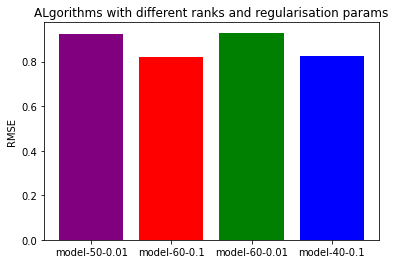

In [ ]:
from matplotlib.pyplot import xlim
import matplotlib.pyplot as plt
import numpy as np
x_pos = np.arange(len(model_names))
plt.bar(model_names,RMSE_validations,color=['purple', 'red', 'green', 'blue', 'cyan'])
plt.xticks(x_pos,model_names)
plt.title('ALgorithms with different ranks and regularisation params')
plt.ylabel('RMSE')
plt.show()
#plt.xlabel('Model names  with format (name-no of latent factors-regularisation_params)')

In [ ]:
# View the predictions
#rank=10 reg_param=0.01
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8373167150705427


In [ ]:
# View the predictions
#rank=50 reg_param=0.1
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8213626072249998


In [ ]:
#rank=20 reg_param=0.05
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8453870771802666


In [ ]:
#rank=20 reg_param=0.05
test_predictions = best_model.transform(validation)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8463621177858696


In [ ]:
#rank=20 reg_param=0.1
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8341117748662664


In [ ]:
#rank=20 reg_param=0.1
test_predictions = best_model.transform(validation)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE)

0.8352477886052904


In [ ]:
from pyspark.ml.recommendation import ALSModel

model = ALSModel.load("/content/drive/MyDrive/models/als_model")

In [ ]:
model.getParam

<bound method Params.getParam of ALSModel: uid=ALS_f96928850a7f, rank=50>

In [ ]:
RMSE_validations

[0.8212674431928401, 0.9294209713259193]

In [ ]:
##Predictions for rank=50 reg_param=0.01
validate_predictions = model.transform(validation)
RMSE_validations.append(evaluator.evaluate(validate_predictions))


In [ ]:
##Predictions for rank=50
test_pred = model.transform(test)
RMSE_test.append(evaluator.evaluate(test_pred))

In [ ]:
print(RMSE_validations)

[0.8212674431928401, 0.9294209713259193, 0.6004729384360469]


In [ ]:
##Predictions for rank=50 reg_param=0.01
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(validate_predictions)
print(RMSE)

In [ ]:
RMSE_validations=[]

In [ ]:
from pyspark.ml.recommendation import ALSModel

model = ALSModel.load("/content/drive/MyDrive/models/als_model_2")



In [ ]:
#Score the model using validation data
##Predictions for rank=60 reg_param=0.1
validate_predictions = model.transform(validation_otherset)
#validate_predictions = best_model.transform(validation)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
print(RMSE_validations[0])

0.8212674431928401


In [ ]:
RMSE_test=[]

In [ ]:
test_predictions = model.transform(test_otherset)
RMSE_test.append(evaluator.evaluate(test_predictions))
print(RMSE_test[0])

0.8212124820909017


In [ ]:
#Fit cross   validator to the 'train' dataset
model = cv.fit(train_otherset)

#Extract best model from the cv model above
best_model = model.bestModel
model_path = temp_path + "/als_model_3"
best_model.save(model_path)

In [ ]:
#Score the model using validation data
#rank=60,reg=0.01
validate_predictions = best_model.transform(validation_otherset)
#validate_predictions = best_model.transform(validation)
RMSE_validations.append(evaluator.evaluate(validate_predictions))
print(RMSE_validations[1])

0.9294209713259193


In [ ]:
print(RMSE_validations)

[0.8212674431928401, 0.9294209713259193, 0.6004729384360469]


In [ ]:
#rank=60,reg=0.01
test_predictions = best_model.transform(test_otherset)
RMSE_test.append(evaluator.evaluate(test_predictions))
print(RMSE_test[1])

0.8212124820909017


In [ ]:
print(RMSE_test)

[0.8212124820909017, 0.9301648899387973, 0.6006150106529102]


In [ ]:
#Fit cross   validator to the 'train' dataset
model = cv.fit(train_otherset)

#Extract best model from the cv model above
best_model = model.bestModel
model_path = temp_path + "/als_model_4"
best_model.save(model_path)

In [ ]:
#Score the model using validation data
#rank=40,reg=0.1
validate_predictions = best_model.transform(validation_otherset)
#validate_predictions = best_model.transform(validation)
RMSE=evaluator.evaluate(validate_predictions)
#RMSE_validations.append(evaluator.evaluate(validate_predictions))
#print(RMSE_validations)

In [ ]:
# Generate n Recommendations for all users
recommendations = best_model.recommendForAllUsers(5)
recommendations.show()

+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{8946, 4.5825987...|
|      3|[{464, 2.674022},...|
|      5|[{8946, 4.796386}...|
|      6|[{9537, 5.193078}...|
|      9|[{6920, 4.249055}...|
|     12|[{8946, 4.8706894...|
|     13|[{4868, 5.1269636...|
|     15|[{9842, 5.1204014...|
|     16|[{7063, 4.851418}...|
|     17|[{8946, 5.3222265...|
|     19|[{8946, 4.0324717...|
|     20|[{5990, 4.9759674...|
|     22|[{8946, 4.533051}...|
|     26|[{8946, 4.6841087...|
|     27|[{4868, 4.6853733...|
|     28|[{8946, 4.940489}...|
|     31|[{8946, 4.2108564...|
|     34|[{8946, 4.5941434...|
|     35|[{6920, 3.84977},...|
|     37|[{8946, 5.3904037...|
+-------+--------------------+
only showing top 20 rows



In [ ]:
nrecommendations = recommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('user_id', col("rec_exp.book_id"), col("rec_exp.rating"))


+-------+--------------------+
|user_id|     recommendations|
+-------+--------------------+
|      1|[{8946, 4.5825987...|
|      3|[{464, 2.674022},...|
|      5|[{8946, 4.796386}...|
|      6|[{9537, 5.193078}...|
|      9|[{6920, 4.249055}...|
|     12|[{8946, 4.8706894...|
|     13|[{4868, 5.1269636...|
|     15|[{9842, 5.1204014...|
|     16|[{7063, 4.851418}...|
|     17|[{8946, 5.3222265...|
+-------+--------------------+



In [ ]:
nrecommendations.limit(10).show()

+-------+-------+---------+
|user_id|book_id|   rating|
+-------+-------+---------+
|      1|   8946|4.5825987|
|      1|   7947|4.4613237|
|      1|   3628|4.3915706|
|      1|   9566|4.3506875|
|      1|   6920|4.3174577|
|      3|    464| 2.674022|
|      3|   4090|2.5850894|
|      3|   6618|2.4757845|
|      3|   7499|2.4717994|
|      3|   4376|2.4188144|
+-------+-------+---------+



In [ ]:
nrecommendations.join(books, on='book_id').filter('user_id = 100').show()

+-------+-------+---------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|book_id|user_id|   rating|             authors|average_rating|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|         publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+-------+-------+---------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|   8946|    100| 4.352078|           ['Hafez']|          4.63|         91|['poetry', 'class...|            46292|https://images.gr...|          eng|                     1380|  5

In [ ]:
ratings.join(books, on='book_id').filter('user_id = 100').sort('rating', ascending=False).limit(10).show()

+-------+-------+------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|book_id|user_id|rating|             authors|average_rating|books_count|              genres|goodreads_book_id|           image_url|language_code|original_publication_year|pages|         publishDate|ratings_1|ratings_2|ratings_3|ratings_4|ratings_5|               title|
+-------+-------+------+--------------------+--------------+-----------+--------------------+-----------------+--------------------+-------------+-------------------------+-----+--------------------+---------+---------+---------+---------+---------+--------------------+
|   8946|    100|   5.0|           ['Hafez']|          4.63|         91|['poetry', 'class...|            46292|https://images.gr...|          eng|                     1380|  566|         

In [ ]:
###Tried executing google colab ,HPC Account but it takes too long to run 

In [ ]:
###Neural Collabarative filtering 


In [ ]:
import os

# data science imports
import numpy as np
import pandas as pd

# sklearn imports
from sklearn.model_selection import train_test_split

# keras/tensorflow imports
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adagrad, Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

# visualization imports
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# path config
data_path = os.path.join(os.environ['DATA_PATH'], 'GoodreadBooks')
ratings_filename = 'ratings.csv'

In [ ]:
df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['user_id', 'book_id', 'rating'],
    dtype={'user_id': 'int32', 'book_id': 'int32', 'rating': 'float32'})

In [ ]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  int32  
 1   book_id  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 68.4 MB


In [ ]:
df_ratings.head()

,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [ ]:
num_users = len(df_ratings.user_id.unique())
num_items = len(df_ratings.book_id.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 53424 unique users and 10000 unique movies in this data set


In [ ]:
user_maxId = df_ratings.user_id.max()
item_maxId = df_ratings.book_id.max()
print('There are {} distinct users and the max of user ID is also {}'.format(num_users, user_maxId))
print('There are {} distinct movies, however, the max of movie ID is {}'.format(num_items, item_maxId))
print('In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space')
print('So we need to do some data cleaning to reduce the dimension of item vector back to {}'.format(num_items))

There are 53424 distinct users and the max of user ID is also 53424
There are 10000 distinct movies, however, the max of movie ID is 10000
In the context of matrix factorization, the current item vector is in unnecessarily high dimensional space
So we need to do some data cleaning to reduce the dimension of item vector back to 10000


In [ ]:
def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='user_id', columns='book_id', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('user_id') \
        .melt(
            id_vars='user_id', 
            value_vars=df_user_item.columns,
            var_name='book_id',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['user_id', 'book_id']).reset_index(drop=True)

In [ ]:
print('reduce item dimension before:')
df_ratings.head()

reduce item dimension before:


,user_id,book_id,rating
0,1,258,5.0
1,2,4081,4.0
2,2,260,5.0
3,2,9296,5.0
4,2,2318,3.0


In [ ]:
df_ratings = reduce_item_dim(df_ratings)
print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,user_id,book_id,rating
0,1,3,5.0
1,1,9,4.0
2,1,10,5.0
3,1,12,4.0
4,1,15,3.0


In [ ]:
df_train, df_test = train_test_split(df_ratings, test_size=0.2, shuffle=True, random_state=99)
print('shape of training data set:')
print(df_train.shape)
print('shape of test data set:')
print(df_test.shape)

shape of training data set:
(4781183, 3)
shape of test data set:
(1195296, 3)


In [ ]:
def get_GMF_model(num_users, num_items, latent_dim, vu_reg, vi_reg):
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, 'tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [ ]:
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        534250      user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        100010      item_input[0][0]                 
______________________________________________________________________________________________

In [ ]:
import numpy as np

user_id_values = np.asarray(df_train.user_id.values).astype(np.float32)
book_id_values=np.asarray(df_train.book_id.values).astype(np.float32)

In [ ]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(GMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[user_id_values, book_id_values],
                      outputs=df_train.rating.values)

Epoch 1/30
56030/56030 [==============================] - 317s 6ms/step - loss: 0.6979 - mean_squared_error: 0.6979 - rmse: 0.8308 - val_loss: 0.7170 - val_mean_squared_error: 0.7170 - val_rmse: 0.8422
Epoch 2/30
56030/56030 [==============================] - 302s 5ms/step - loss: 0.6474 - mean_squared_error: 0.6474 - rmse: 0.7999 - val_loss: 0.7088 - val_mean_squared_error: 0.7088 - val_rmse: 0.8371
Epoch 3/30
56030/56030 [==============================] - 294s 5ms/step - loss: 0.6198 - mean_squared_error: 0.6198 - rmse: 0.7824 - val_loss: 0.7087 - val_mean_squared_error: 0.7087 - val_rmse: 0.8370
Epoch 4/30
56030/56030 [==============================] - 261s 5ms/step - loss: 0.6024 - mean_squared_error: 0.6024 - rmse: 0.7712 - val_loss: 0.7085 - val_mean_squared_error: 0.7085 - val_rmse: 0.8370
Epoch 5/30
56030/56030 [==============================] - 281s 5ms/step - loss: 0.5904 - mean_squared_error: 0.5904 - rmse: 0.7634 - val_loss: 0.7114 - val_mean_squared_error: 0.7114 - val_rms

In [ ]:
def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

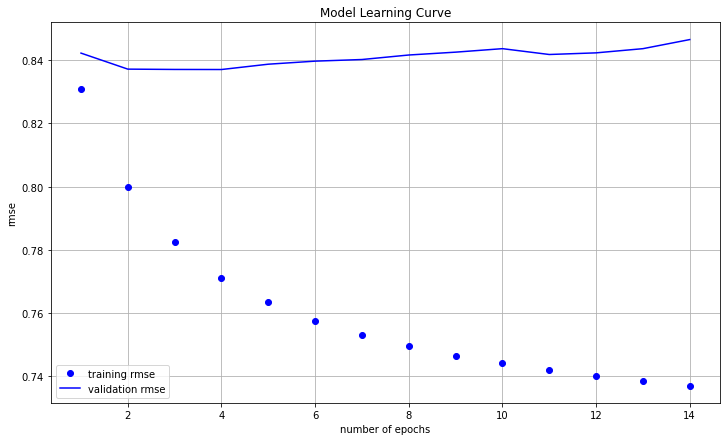

In [ ]:
plot_learning_curve(history, 'rmse')

In [ ]:
# define rmse function
rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

In [ ]:
user_id_test_values = np.asarray(df_test.user_id.values).astype(np.float32)
book_id_test_values=np.asarray(df_test.book_id.values).astype(np.float32)

In [ ]:
 #load best model
GMF_model = get_GMF_model(num_users, num_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = GMF_model.predict([user_id_test_values, book_id_test_values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8425


In [ ]:
def get_MLP_model(num_users, num_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        1709600     user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        320032      item_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[user_id_values, book_id_values],
                      outputs=df_train.rating.values)

Epoch 1/30
56030/56030 [==============================] - 1649s 29ms/step - loss: 0.7926 - mean_squared_error: 0.7926 - rmse: 0.8802 - val_loss: 0.7377 - val_mean_squared_error: 0.7377 - val_rmse: 0.8543
Epoch 2/30
56030/56030 [==============================] - 702s 13ms/step - loss: 0.7181 - mean_squared_error: 0.7181 - rmse: 0.8427 - val_loss: 0.7225 - val_mean_squared_error: 0.7225 - val_rmse: 0.8458
Epoch 3/30
56030/56030 [==============================] - 667s 12ms/step - loss: 0.6831 - mean_squared_error: 0.6831 - rmse: 0.8217 - val_loss: 0.7077 - val_mean_squared_error: 0.7077 - val_rmse: 0.8369
Epoch 4/30
56030/56030 [==============================] - 695s 12ms/step - loss: 0.6550 - mean_squared_error: 0.6550 - rmse: 0.8045 - val_loss: 0.6998 - val_mean_squared_error: 0.6998 - val_rmse: 0.8320
Epoch 5/30
56030/56030 [==============================] - 33357s 595ms/step - loss: 0.6309 - mean_squared_error: 0.6309 - rmse: 0.7894 - val_loss: 0.6993 - val_mean_squared_error: 0.6993 

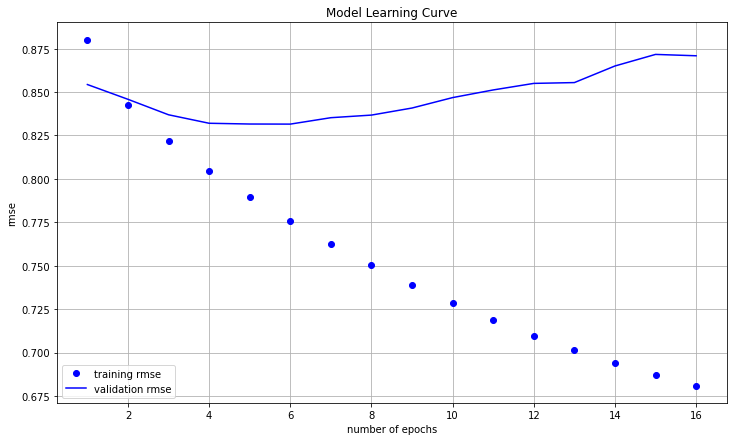

In [ ]:
plot_learning_curve(history, 'rmse')

In [ ]:
# load best model
MLP_model = get_MLP_model(num_users, num_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = MLP_model.predict([user_id_test_values,book_id_test_values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8367


In [ ]:
def get_NeuMF_model(num_users, num_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    
     # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=num_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=num_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=num_items + 1,output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        1709600     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        320032      item_input[0][0]                 
____________________________________________________________________________________________

In [ ]:
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[user_id_values, book_id_values],
                      outputs=df_train.rating.values)

Epoch 1/30
56030/56030 [==============================] - 823s 15ms/step - loss: 0.7956 - mean_squared_error: 0.7956 - rmse: 0.8792 - val_loss: 0.7221 - val_mean_squared_error: 0.7221 - val_rmse: 0.8451
Epoch 2/30
56030/56030 [==============================] - 842s 15ms/step - loss: 0.6652 - mean_squared_error: 0.6652 - rmse: 0.8109 - val_loss: 0.7075 - val_mean_squared_error: 0.7075 - val_rmse: 0.8363
Epoch 3/30
56030/56030 [==============================] - 819s 15ms/step - loss: 0.6094 - mean_squared_error: 0.6094 - rmse: 0.7757 - val_loss: 0.7109 - val_mean_squared_error: 0.7109 - val_rmse: 0.8381
Epoch 4/30
56030/56030 [==============================] - 842s 15ms/step - loss: 0.5741 - mean_squared_error: 0.5741 - rmse: 0.7526 - val_loss: 0.7126 - val_mean_squared_error: 0.7126 - val_rmse: 0.8393
Epoch 5/30
56030/56030 [==============================] - 844s 15ms/step - loss: 0.5468 - mean_squared_error: 0.5468 - rmse: 0.7342 - val_loss: 0.7226 - val_mean_squared_error: 0.7226 - va

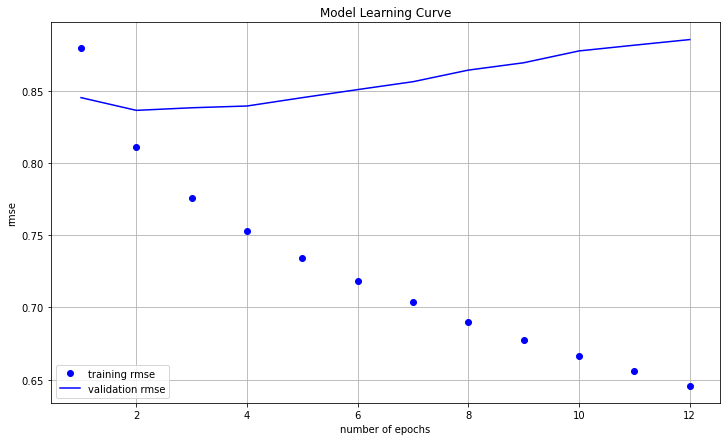

In [ ]:
plot_learning_curve(history, 'rmse')

In [ ]:
# load best model
NeuMF_model = get_NeuMF_model(
    num_users=num_users,
    num_items=num_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, 'tmp/model.hdf5'))
# make prediction using test data
predictions = NeuMF_model.predict([user_id_test_values, book_id_test_values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8417
